# **Optimizing Stock Trading Decisions: Utilizing Agent-Based Models and Historical Data for Buy/Sell Predictions**

Zeliha Ural Merpez

2024-10-22

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
symbols = ['AMT', 'ORCL', 'MSFT', 'AMX', 'AAPL', 'GOOGL', 'AMZN', 'BA', 'EXPE', 'EA']

data = {} # Download historical stock data for multiple firms
for symbol in symbols:
    data[symbol] = yf.download(symbol, start='2019-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
short_window = 20  # Short-term moving average
long_window = 50   # Long-term moving average

In [4]:
class AdaptiveSlowAgent:
    def __init__(self, initial_balance, initial_date):
        self.balance = initial_balance
        self.date = initial_date
        self.daily_balance = []
        self.shares = {symbol: 0 for symbol in symbols}
        self.performance_history = {symbol: [] for symbol in symbols} # Gain from selling stocks obtained by sold quantity*(price - avg book value price)
        self.wait_time = {symbol: 2 for symbol in symbols}  # Start with a wait time for each firm
        self.weights = {symbol: 1/len(symbols) for symbol in symbols} # Start with an equal weight for each firm
        self.share_val = {symbol: [0, 0] for symbol in symbols} #Start with 0 book value and 0 share value for each firm
        self.shares_history = {symbol: [] for symbol in symbols} #Add buy and sell number of shares and current prices

    def set_current_date(self, current_date):
        self.date = current_date


    def update_shares_history(self, symbol, buy_sell, quantity, price):
        self.shares_history[symbol].append({
            'type' : buy_sell,
            'quantity': quantity,
            'price': price,
            'date': self.date
        })

    def decide(self, prices, short_mas, long_mas, symbols, expected_trs):
        self.daily_balance.append(self.value(prices))
        expected_returns = {}
        for symbol in symbols:
            expected_returns[symbol] = long_mas[symbol] - short_mas[symbol] - expected_trs[symbol]

        total_expected_positive = sum([x for x in expected_returns.values() if x > 0])
        total_expected_negative = sum([x for x in expected_returns.values() if x < 0])

        for symbol in symbols:
            price = prices[symbol]
            short_ma = short_mas[symbol]
            long_ma = long_mas[symbol]
            expected_tr = expected_trs[symbol]
            expected_return = expected_returns[symbol]

            if self.wait_time[symbol] > 0:
                self.wait_time[symbol] -= 1  # Reduce wait time for next decision
                continue  # Skip decision if waiting


            if expected_return > 0 and self.balance > 0:  # Buy signal
                weight = expected_return / total_expected_positive
                self.weights[symbol] = weight
                quantity = int(weight * (self.balance // price))
                if quantity > 0:
                    self.buy(price, quantity, symbol)

            elif expected_return < 0 and self.shares[symbol] > 0:  # Sell signal
                weight = expected_return / total_expected_negative
                self.weights[symbol] = -1 * weight # Sell weight
                quantity = int(weight * self.shares[symbol])
                if quantity > 0:
                    self.sell(price, quantity, symbol)


    def buy(self, price, quantity, symbol):
        total_cost = price * quantity
        if total_cost <= self.balance:
            self.shares[symbol] += quantity
            self.balance -= total_cost
            self.share_val[symbol][0] -= total_cost
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'buy', quantity, price)


    def sell(self, price, quantity, symbol):
        if quantity <= self.shares[symbol]:
            self.update_performance(symbol, price, quantity)
            self.share_val[symbol][0] *= (1-quantity/self.shares[symbol])
            self.shares[symbol] -= quantity
            self.balance += price * quantity
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'sell', quantity, price)


    def update_performance(self, symbol, price, quantity):
        gain = quantity*(price + self.share_val[symbol][0]/self.shares[symbol]) # Calculate gain using average shares value from the book value
        self.performance_history[symbol].append({'gain': gain, 'date': self.date})

        if gain > 0: # Adjust wait time based on performance
            self.wait_time[symbol] = max(0, self.wait_time[symbol] - 1)  # Shorten wait time if expecting gain
        else:
            self.wait_time[symbol] += 1  # Increase wait time if expecting lose

    def value(self, current_prices):
        total_value = self.balance
        for symbol in symbols:
            total_value += self.shares[symbol] * current_prices[symbol]
        return total_value

In [5]:
class AdaptiveFastAgent:
    def __init__(self, initial_balance, initial_date):
        self.balance = initial_balance
        self.date = initial_date
        self.daily_balance = []
        self.shares = {symbol: 0 for symbol in symbols}
        self.performance_history = {symbol: [] for symbol in symbols} # Gain from selling stocks obtained by sold quantity*(price - avg book value price)
        self.wait_time = {symbol: 0 for symbol in symbols}  # Start with a wait time for each firm
        self.weights = {symbol: 1/len(symbols) for symbol in symbols} # Start with an equal weight for each firm
        self.share_val = {symbol: [0, 0] for symbol in symbols} #Start with 0 book value and 0 share value for each firm
        self.shares_history = {symbol: [] for symbol in symbols} #Add buy and sell number of shares and current prices

    def set_current_date(self, current_date):
        self.date = current_date


    def update_shares_history(self, symbol, buy_sell, quantity, price):
        self.shares_history[symbol].append({
            'type' : buy_sell,
            'quantity': quantity,
            'price': price,
            'date': self.date
        })

    def decide(self, prices, short_mas, long_mas, symbols, expected_trs):
        self.daily_balance.append(self.value(prices))
        expected_returns = {}
        for symbol in symbols:
            expected_returns[symbol] = long_mas[symbol] - short_mas[symbol] - expected_trs[symbol]

        total_expected_positive = sum([x for x in expected_returns.values() if x > 0])
        total_expected_negative = sum([x for x in expected_returns.values() if x < 0])

        for symbol in symbols:
            price = prices[symbol]
            short_ma = short_mas[symbol]
            long_ma = long_mas[symbol]
            expected_tr = expected_trs[symbol]
            expected_return = expected_returns[symbol]

            if self.wait_time[symbol] > 0:
                self.wait_time[symbol] -= 1  # Reduce wait time for next decision
                continue  # Skip decision if waiting


            if expected_return > 0 and self.balance > 0:  # Buy signal
                weight = expected_return / total_expected_positive
                self.weights[symbol] = weight
                quantity = int(weight * (self.balance // price))
                if quantity > 0:
                    self.buy(price, quantity, symbol)

            elif expected_return < 0 and self.shares[symbol] > 0:  # Sell signal
                self.weights[symbol] = -1 # Sell all shares
                quantity = self.shares[symbol]
                if quantity > 0:
                    self.sell(price, quantity, symbol)


    def buy(self, price, quantity, symbol):
        total_cost = price * quantity
        if total_cost <= self.balance:
            self.shares[symbol] += quantity
            self.balance -= total_cost
            self.share_val[symbol][0] -= total_cost
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'buy', quantity, price)


    def sell(self, price, quantity, symbol):
        if quantity <= self.shares[symbol]:
            self.update_performance(symbol, price, quantity)
            self.share_val[symbol][0] *= (1-quantity/self.shares[symbol])
            self.shares[symbol] -= quantity
            self.balance += price * quantity
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'sell', quantity, price)


    def update_performance(self, symbol, price, quantity):
        gain = quantity*(price + self.share_val[symbol][0]/self.shares[symbol]) # Calculate gain using average shares value from the book value
        self.performance_history[symbol].append({'gain': gain, 'date': self.date})

        if gain > 0: # Adjust wait time based on performance
            self.wait_time[symbol] = max(0, self.wait_time[symbol] - 1)  # Shorten wait time if expecting gain
        else:
            self.wait_time[symbol] += 1  # Increase wait time if expecting lose

    def value(self, current_prices):
        total_value = self.balance
        for symbol in symbols:
            total_value += self.shares[symbol] * current_prices[symbol]
        return total_value

In [6]:
expected_trs = {symbol: 0 for symbol in symbols} # Start with uniform expected thresholds for each symbol

In [7]:
expected_trs

{'AMT': 0,
 'ORCL': 0,
 'MSFT': 0,
 'AMX': 0,
 'AAPL': 0,
 'GOOGL': 0,
 'AMZN': 0,
 'BA': 0,
 'EXPE': 0,
 'EA': 0}

In [8]:
date_list = list(data['AMT'].index)  # check data whether or not the index is same for all symbols
for symbol in symbols:
    new_date = list(data[symbol].index)
    if date_list != new_date:
        print(symbol)

In [9]:
initial_balance = 10000
initial_date = data['AMT'].index[long_window]
slow_agent = AdaptiveSlowAgent(initial_balance, initial_date)
fast_agent = AdaptiveFastAgent(initial_balance, initial_date)

for i in range(long_window, len(data[symbols[0]])):
    current_date = data['AMT'].index[i]
    slow_agent.set_current_date(current_date)
    fast_agent.set_current_date(current_date)

    current_prices = {symbol: data[symbol]['Close'].iloc[i] for symbol in symbols}
    short_mas = {symbol: data[symbol]['Close'].rolling(window=short_window).mean().iloc[i] for symbol in symbols}
    long_mas = {symbol: data[symbol]['Close'].rolling(window=long_window).mean().iloc[i] for symbol in symbols}

    slow_agent.decide(current_prices, short_mas, long_mas, symbols, expected_trs)    # Slow Agent Decision for each symbol
    fast_agent.decide(current_prices, short_mas, long_mas, symbols, expected_trs)    # Fast Agent Decision for each symbol

slow_final_value = slow_agent.value(current_prices)
fast_final_value = fast_agent.value(current_prices)
print(f"Slow Agent Final Portfolio Value: ${slow_final_value:.2f}")
print(f"Fast Agent Final Portfolio Value: ${fast_final_value:.2f}")

Slow Agent Final Portfolio Value: $17748.25
Fast Agent Final Portfolio Value: $39338.40


In [10]:
dates = list(data['AMT'].index)[-1208:]

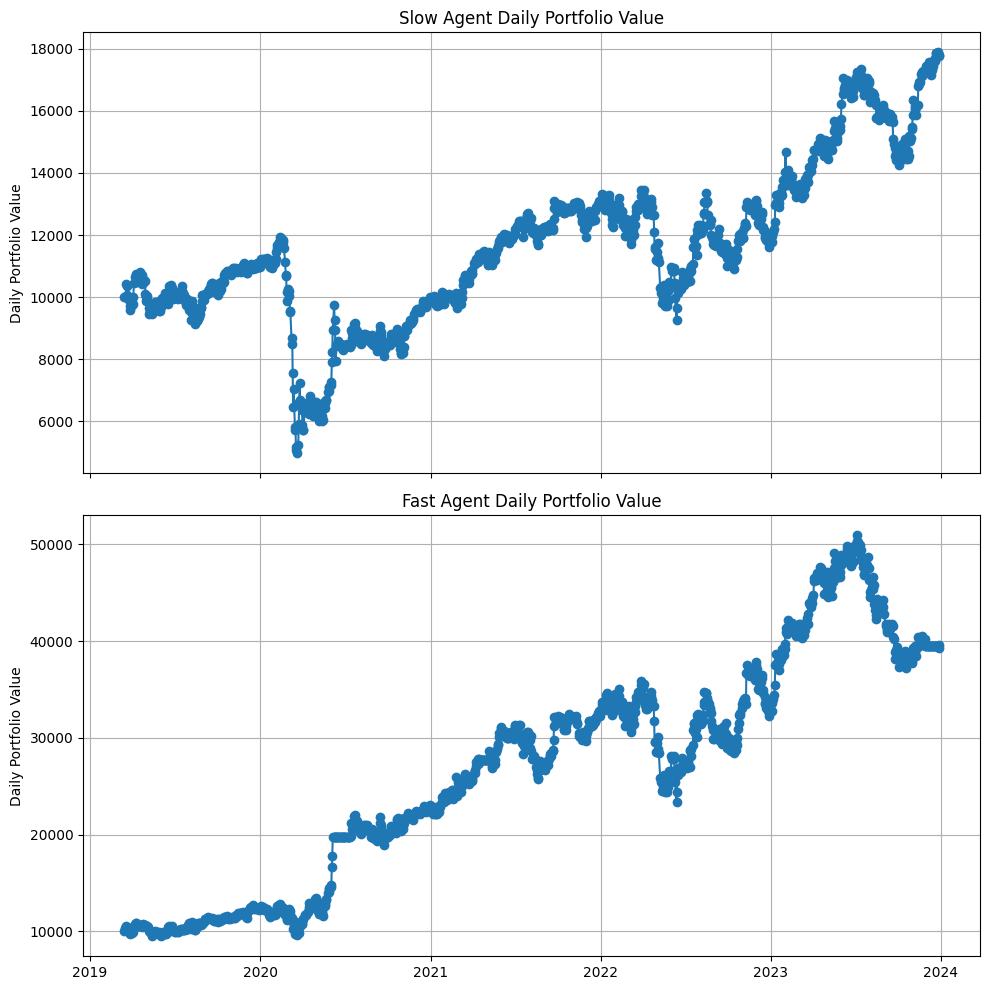

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

axs[0].plot(dates, slow_agent.daily_balance, marker='o', linestyle='-', label='Slow Agent ')
axs[0].set_title('Slow Agent Daily Portfolio Value')
axs[0].set_ylabel('Daily Portfolio Value')
axs[0].grid()

axs[1].plot(dates, fast_agent.daily_balance, marker='o', linestyle='-', label='Fast Agent ')
axs[1].set_title('Fast Agent Daily Portfolio Value')
axs[1].set_ylabel('Daily Portfolio Value')
axs[1].grid()

plt.tight_layout()
plt.show()

In [12]:
print('Slow Agent Final Book Values & Stock Current Cash Value')
pd.DataFrame(slow_agent.share_val, index=['Book Value', 'Stock Current Cash Value'])

Slow Agent Final Book Values & Stock Current Cash Value


,AMT,ORCL,MSFT,AMX,AAPL,GOOGL,AMZN,BA,EXPE,EA
Book Value,-956.795184,-4599.559693,-264.076808,-3862.521370,-282.204034,-5581.699951,-281.109982,-588.235057,-370.56583,-115.983104
Stock Current Cash Value,1030.899963,4555.420105,272.230011,3574.360088,301.179993,5625.199875,434.550018,790.530029,472.00000,130.259995


In [13]:
print('Fast Agent Final Book Values & Stock Current Cash Value')
pd.DataFrame(fast_agent.share_val, index=['Book Value', 'Stock Current Cash Value'])

Fast Agent Final Book Values & Stock Current Cash Value


,AMT,ORCL,MSFT,AMX,AAPL,GOOGL,AMZN,BA,EXPE,EA
Book Value,-0.0,-39515.620911,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
Stock Current Cash Value,0.0,39515.620911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


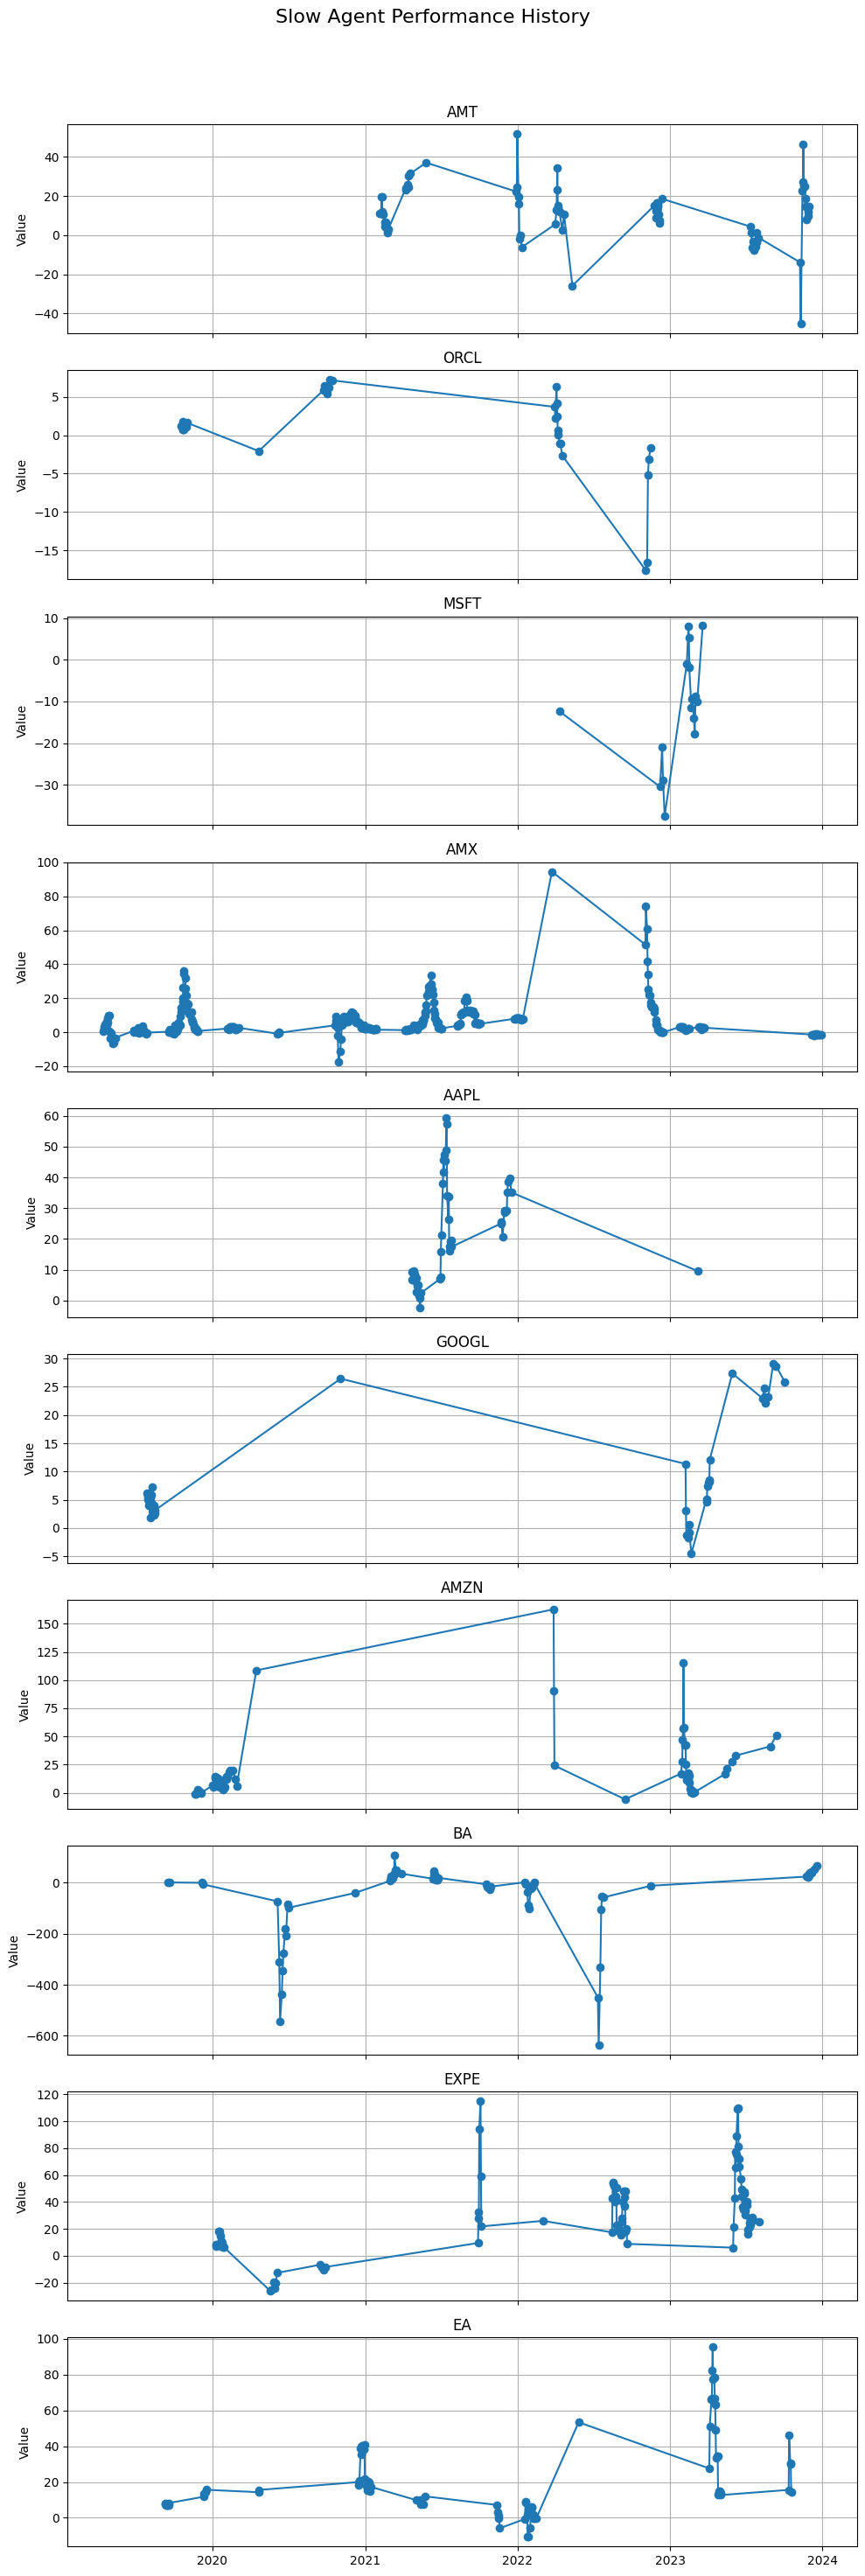

In [14]:
fig, axs = plt.subplots(nrows=len(symbols), ncols=1, figsize=(10, 30), sharex=True)

for i in range(0, len(symbols)):
    symbol = symbols[i]
    df_sub = pd.DataFrame(slow_agent.performance_history[symbol])
    axs[i].plot(df_sub['date'], df_sub['gain'], marker='o', label=symbol)
    axs[i].set_title(symbol)
    axs[i].set_ylabel('Value')
    axs[i].grid()


fig.suptitle('Slow Agent Performance History', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

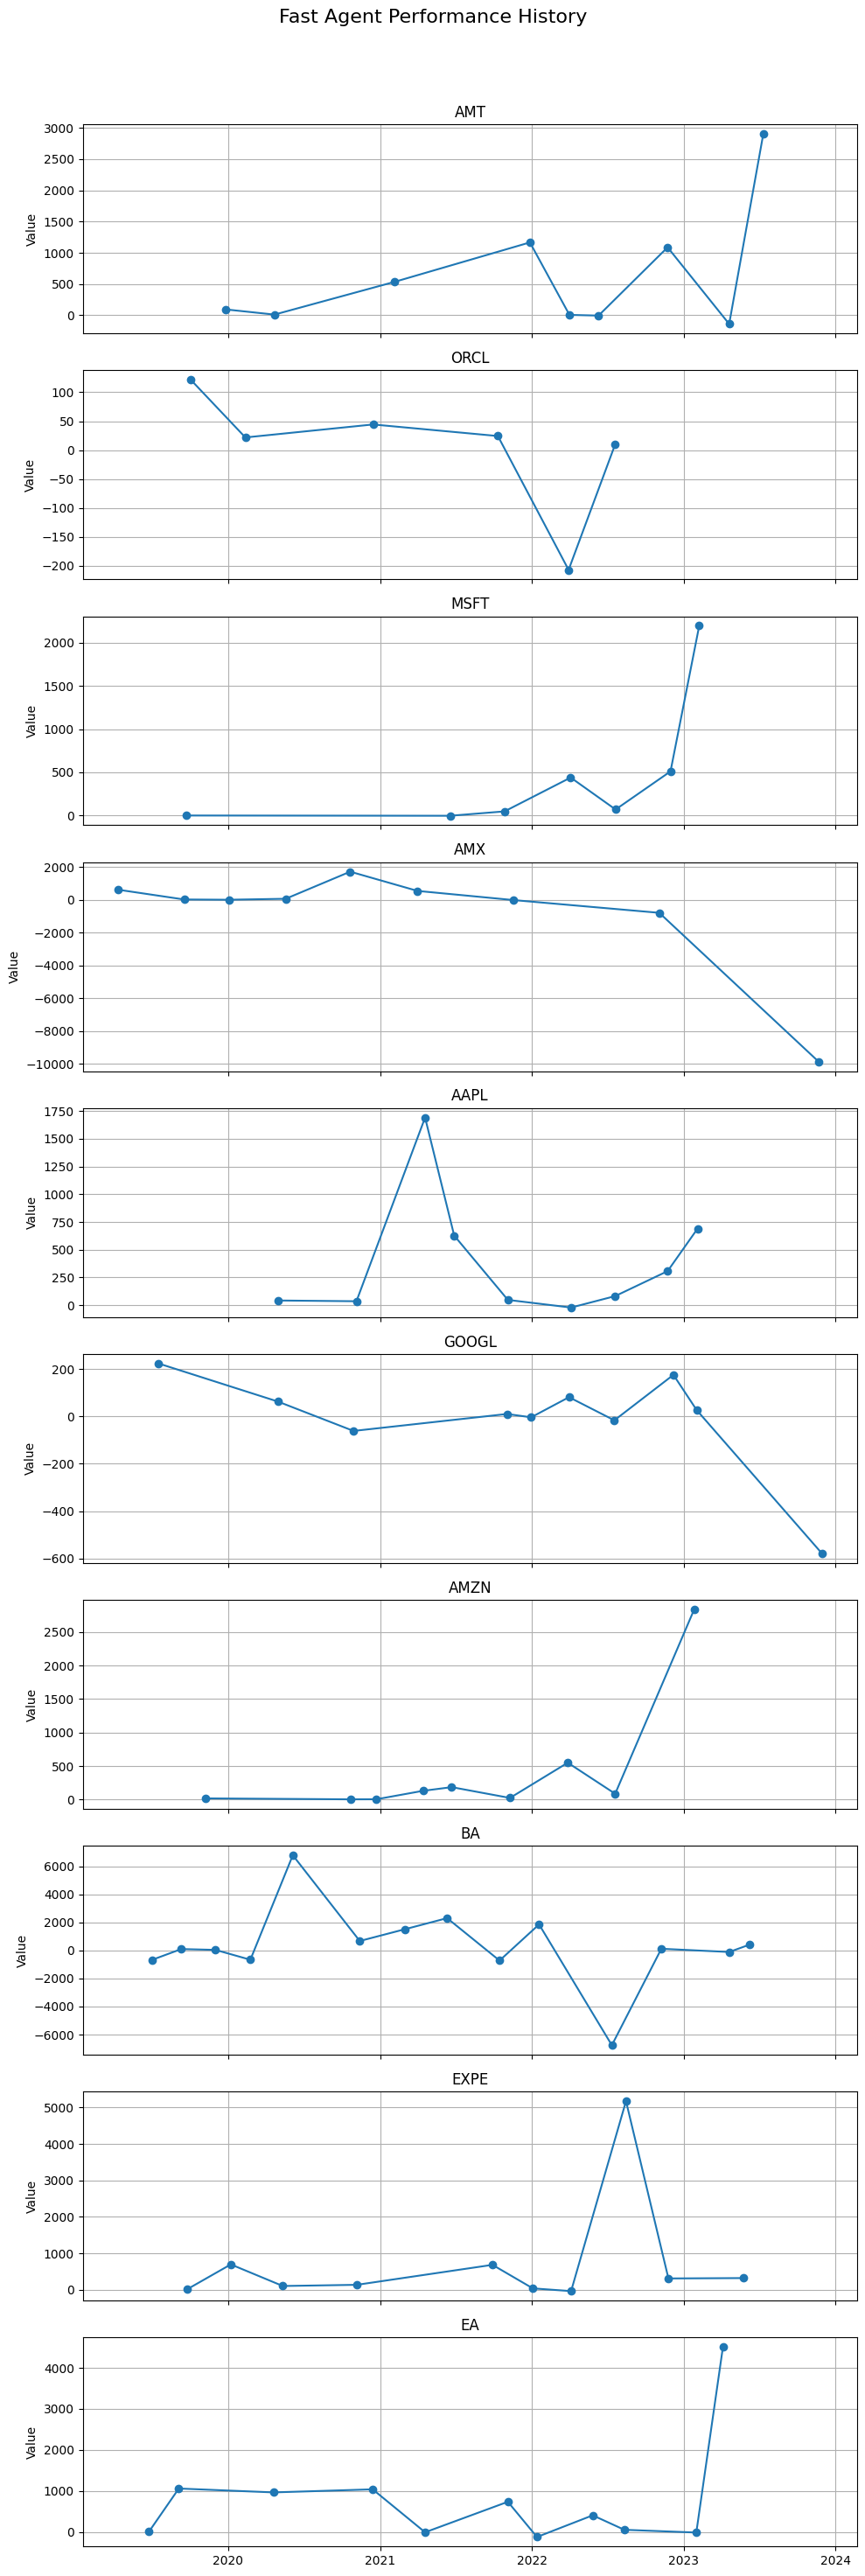

In [15]:
fig, axs = plt.subplots(nrows=len(symbols), ncols=1, figsize=(10, 30), sharex=True)

for i in range(0, len(symbols)):
    symbol = symbols[i]
    df_sub = pd.DataFrame(fast_agent.performance_history[symbol])
    axs[i].plot(df_sub['date'], df_sub['gain'], marker='o', label=symbol)
    axs[i].set_title(symbol)
    axs[i].set_ylabel('Value')
    axs[i].grid()


fig.suptitle('Fast Agent Performance History', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
pd.DataFrame(slow_agent.weights, index=['Slow Weights']).T

,Slow Weights
AMT,-0.161919
ORCL,1.000000
MSFT,-0.092861
AMX,-0.007631
AAPL,-0.079117
GOOGL,-0.020400
AMZN,-0.069877
BA,-0.325804
EXPE,-0.197812
EA,-0.044579


In [17]:
pd.concat([pd.DataFrame(slow_agent.weights, index=['Slow Agent Weights']).T, pd.DataFrame(fast_agent.weights, index=['Fast Agent Weights']).T], axis=1)

,Slow Agent Weights,Fast Agent Weights
AMT,-0.161919,0.010629
ORCL,1.000000,1.000000
MSFT,-0.092861,0.008881
AMX,-0.007631,-1.000000
AAPL,-0.079117,0.024670
GOOGL,-0.020400,-1.000000
AMZN,-0.069877,0.010812
BA,-0.325804,0.258319
EXPE,-0.197812,0.032198
EA,-0.044579,0.000794


In [18]:
df_s = pd.DataFrame({'Symbol': symbols,
              'Slow # of Transactions' : [len(slow_agent.shares_history[symbol]) for symbol in symbols]}).set_index('Symbol')
df_f = pd.DataFrame({'Symbol': symbols,
              'Fast # of Transactions' : [len(fast_agent.shares_history[symbol]) for symbol in symbols]}).set_index('Symbol')
pd.concat([df_s, df_f], axis=1)

,Slow # of Transactions,Fast # of Transactions
Symbol,,
AMT,156,64
ORCL,83,41
MSFT,29,37
AMX,451,60
AAPL,90,54
GOOGL,86,48
AMZN,151,76
BA,183,87
EXPE,184,78


Note: The number of transactions for slow is higher due to the agents choice of not selling all shares when the expected returns start falling. Slow agent sells with weights, whereas fast agent choose to sell all shares at once.

In [19]:
df_s_list =[pd.DataFrame(slow_agent.shares_history[symbol]) for symbol in symbols]
for i in range(len(symbols)):
    df_s_list[i]['Symbol'] = symbols[i]

df_f_list =[pd.DataFrame(fast_agent.shares_history[symbol]) for symbol in symbols]
for i in range(len(symbols)):
    df_f_list[i]['Symbol'] = symbols[i]

In [20]:
df_s_agg = []
for i in range(len(symbols)):
  df_s_agg.append(df_s_list[i].groupby('type').agg(symbol = ('Symbol', 'first'), slow_total_quantity = ('quantity', 'count'), slow_mean_price = ('price', 'mean')))

df_s = pd.concat(df_s_agg)

df_f_agg = []
for i in range(len(symbols)):
  df_f_agg.append(df_f_list[i].groupby('type').agg(symbol_1 = ('Symbol', 'first'), fast_total_quantity = ('quantity', 'count'), fast_mean_price = ('price', 'mean')))

df_f = pd.concat(df_f_agg)

pd.concat([df_s, df_f], axis=1)[['symbol', 'slow_total_quantity', 'fast_total_quantity', 'slow_mean_price',	'fast_mean_price']]

,symbol,slow_total_quantity,fast_total_quantity,slow_mean_price,fast_mean_price
type,,,,,
buy,AMT,84,55,217.977739,232.692728
sell,AMT,72,9,227.913611,236.134445
buy,ORCL,46,35,77.469565,68.541428
sell,ORCL,37,6,66.132433,70.661666
buy,MSFT,13,30,272.603847,263.910333
sell,MSFT,16,7,258.207502,260.607143
buy,AMX,104,51,17.152500,15.439804
sell,AMX,347,9,16.528444,15.615555
buy,AAPL,43,45,129.606743,135.185278


# Change expected thresholds

Getting uniform zero thresholds is actually the base we start. Optimizing the thresholds can be done in few different ways:

1. Getting the same unique constant for all symbols,

2. Getting some firm dependent values from the data directly, i.e. difference of short_ma and long_ma, stock closing price, yearly CAR, ...

3. Getting some score for firms using text data like Earnings Announcement, News, Patent Data, ...

4. Combining some of the scoring after normalizing the data into some formula to be used:

$$ a*x_i + b$$

or,

$$a*x_i + b*y+i +c.$$

5. Changing the last additive constants via yearly general performace ($a_i, b_i, c_i$ )....

I will explore one option below for the symbol values obtained by closing stock prices and formula $a*x_i + b$.



In [60]:
find_tres = []
for symbol in symbols:
    find_tres.append([data[symbol]['Close'].iloc[0]])

scaler = MinMaxScaler()
normalized_tres = scaler.fit_transform(find_tres)

expected_trs = {}
for i in range(len(find_tres)):
    expected_trs[symbols[i]] = normalized_tres[i][0]
expected_trs

{'AMT': 0.45951281653169185,
 'ORCL': 0.09873508341256582,
 'MSFT': 0.2795768612033015,
 'AMX': 0.0,
 'AAPL': 0.08016563654814693,
 'GOOGL': 0.12304358198483875,
 'AMZN': 0.20140564147525344,
 'BA': 1.0,
 'EXPE': 0.3147099875642238,
 'EA': 0.2124486539273042}

In [22]:
all_results = []
for b in range(-10, 10):
    for a in range(-20, 20):
        new_tres = {symbol: expected_trs[symbol]*a + b for symbol in symbols}
        initial_balance = 10000
        initial_date = data['AMT'].index[long_window]
        slow_agent = AdaptiveSlowAgent(initial_balance, initial_date)
        fast_agent = AdaptiveFastAgent(initial_balance, initial_date)

        for i in range(long_window, len(data[symbols[0]])):
            current_date = data['AMT'].index[i]
            slow_agent.set_current_date(current_date)
            fast_agent.set_current_date(current_date)
            current_prices = {symbol: data[symbol]['Close'].iloc[i] for symbol in symbols}
            short_mas = {symbol: data[symbol]['Close'].rolling(window=short_window).mean().iloc[i] for symbol in symbols}
            long_mas = {symbol: data[symbol]['Close'].rolling(window=long_window).mean().iloc[i] for symbol in symbols}

            # Slow Agent Decision for each symbol
            slow_agent.decide(current_prices, short_mas, long_mas, symbols, new_tres)
            fast_agent.decide(current_prices, short_mas, long_mas, symbols, new_tres)
            all_results.append({
                'a': a,
                'b': b,
                'slow_value': round(slow_agent.value(current_prices)),
                'fast_value': round(fast_agent.value(current_prices))
            })
pd.DataFrame(all_results)

,a,b,slow_value,fast_value
0,-20,-10,10000,10000
1,-20,-10,10000,10064
2,-20,-10,10000,10070
3,-20,-10,10045,10141
4,-20,-10,10200,10324
...,...,...,...,...
966395,19,9,12767,9397
966396,19,9,12772,9397
966397,19,9,12770,9397
966398,19,9,12774,9397


## work on thresholds depending on first 50 day performance

In [25]:
final_df = pd.DataFrame(all_results).drop_duplicates(['a', 'b'], keep='last')
final_df

,a,b,slow_value,fast_value
1207,-20,-10,20246,20925
2415,-19,-10,20206,20830
3623,-18,-10,20440,20819
4831,-17,-10,20908,20859
6039,-16,-10,20830,20938
...,...,...,...,...
961567,15,9,14905,10392
962775,16,9,14874,11238
963983,17,9,14278,11511
965191,18,9,12986,9851


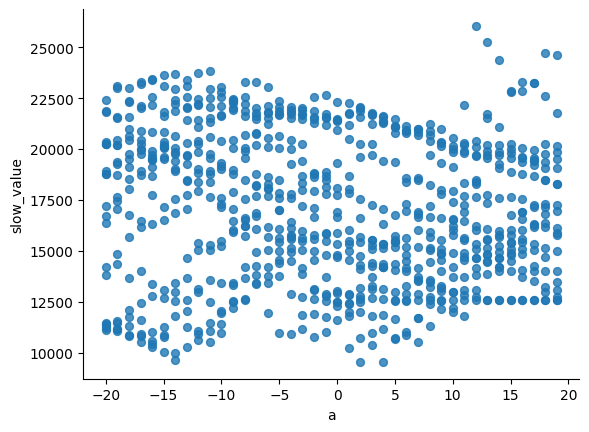

In [32]:
# @title a vs slow_value

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='a', y='slow_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

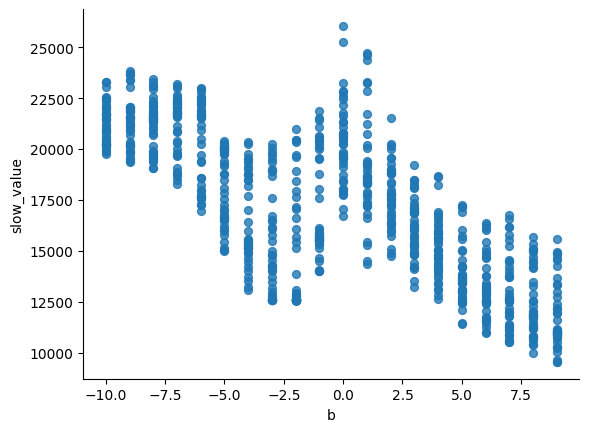

In [30]:
# @title b vs slow_value

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='b', y='slow_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

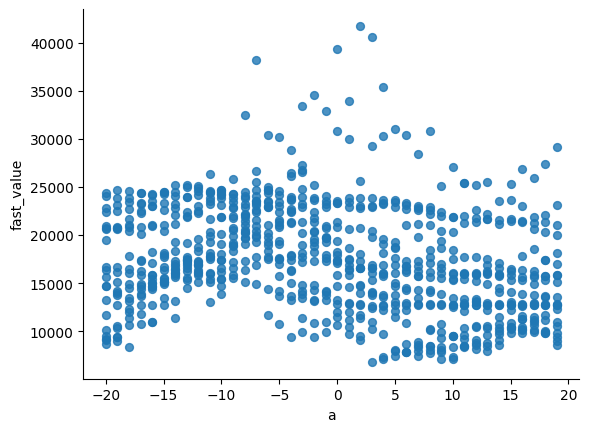

In [33]:
# @title a vs fast_value

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='a', y='fast_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

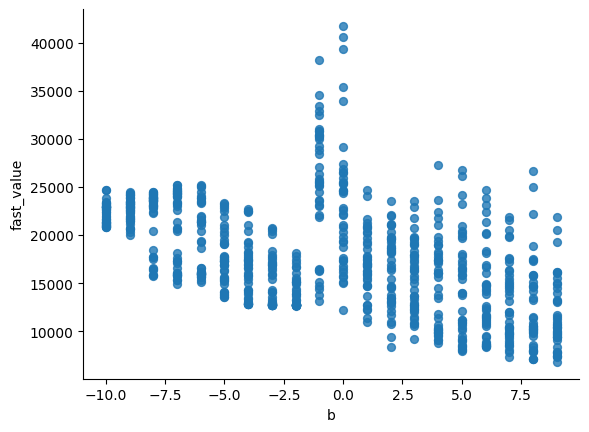

In [39]:
# @title b vs fast_value

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='b', y='fast_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [40]:
max_slow = final_df[final_df['slow_value'] == max(final_df['slow_value'])]
print('The maximum final portfolio for slow agent is obtained by ax+b where: ')
print('a = ', max_slow['a'].iloc[0], ' b = ', max_slow['b'].iloc[0])
print('Final portfolio = ', max(final_df['slow_value']))


The maximum final portfolio for slow agent is obtained by ax+b where: 
a =  12  b =  0
Final portfolio =  26044


In [43]:
max_fast = final_df[final_df['fast_value'] == max(final_df['fast_value'])]
print('The maximum final portfolio for slow agent is obtained by ax+b where: ')
print('a = ', max_fast['a'].iloc[0], ' b = ', max_fast['b'].iloc[0])
print('Final portfolio = ', max(final_df['fast_value']))

The maximum final portfolio for slow agent is obtained by ax+b where: 
a =  2  b =  0
Final portfolio =  41750


In [26]:
final_df.to_csv('all_results.csv')

## Check the maximum daily value obtained for different constants or not.

In [50]:
daily_max_slow = pd.DataFrame(all_results).sort_values(by = 'slow_value', ascending=False).iloc[0]
print('The maximum daily portfolio for slow agent is obtained by ax+b where: ')
print('a = ', daily_max_slow['a'], ' b = ', daily_max_slow['b'])
print('Maximum daily portfolio = ', daily_max_slow['slow_value'])


The maximum daily portfolio for slow agent is obtained by ax+b where: 
a =  12  b =  0
Maximum daily portfolio =  28555


In [51]:
daily_max_fast = pd.DataFrame(all_results).sort_values(by = 'fast_value', ascending=False).iloc[0]
print('The maximum daily portfolio for fast agent is obtained by ax+b where: ')
print('a = ', daily_max_fast['a'], ' b = ', daily_max_fast['b'])
print('Maximum daily portfolio = ', daily_max_fast['fast_value'])

The maximum daily portfolio for fast agent is obtained by ax+b where: 
a =  2  b =  0
Maximum daily portfolio =  53791


# Addressing the Challenges of Unlimited Transactions and Minimum Thresholds in Investment Strategies

Previous agents do not have restrictions on the number of transactions they can execute. Additionally, there is no minimum threshold for buy and sell operations. This lack of limitations can lead to suboptimal strategies for human investors, as executing transactions in small quantities—such as purchasing or selling a single share from ten different companies—may not be ideal in a context where each transaction incurs costs.

In [62]:
class FlexibleSlowAgent:
    def __init__(self, initial_balance, initial_date):
        self.balance = initial_balance
        self.date = initial_date
        self.daily_balance = []
        self.shares = {symbol: 0 for symbol in symbols}
        self.performance_history = {symbol: [] for symbol in symbols} # Gain from selling stocks obtained by sold quantity*(price - avg book value price)
        self.wait_time = {symbol: 2 for symbol in symbols}  # Start with a wait time for each firm
        self.weights = {symbol: 1/len(symbols) for symbol in symbols} # Start with an equal weight for each firm
        self.share_val = {symbol: [0, 0] for symbol in symbols} #Start with 0 book value and 0 share value for each firm
        self.shares_history = {symbol: [] for symbol in symbols} #Add buy and sell number of shares and current prices

    def set_current_date(self, current_date):
        self.date = current_date


    def update_shares_history(self, symbol, buy_sell, quantity, price):
        self.shares_history[symbol].append({
            'type' : buy_sell,
            'quantity': quantity,
            'price': price,
            'date': self.date
        })

    def decide(self, prices, short_mas, long_mas, symbols, expected_trs):
        self.daily_balance.append(self.value(prices))
        expected_returns = {}
        for symbol in symbols:
            expected_returns[symbol] = long_mas[symbol] - short_mas[symbol] - expected_trs[symbol]

        max_3_returns = sorted(list(expected_returns.values()))[-3:]  # Limiting to buy option with only maximum 3 positive returns
        min_3_returns = sorted(list(expected_returns.values()))[:3]
        total_expected_positive = sum([x for x in max_3_returns if x > 0 ])
        total_expected_negative = sum([x for x in min_3_returns if x < 0])

        for symbol in symbols:
            price = prices[symbol]
            short_ma = short_mas[symbol]
            long_ma = long_mas[symbol]
            #expected_tr = expected_trs[symbol]
            expected_return = expected_returns[symbol]

            if self.wait_time[symbol] > 0:
                self.wait_time[symbol] -= 1  # Reduce wait time for next decision
                continue  # Skip decision if waiting


            if expected_return > 0 and (expected_return in (max_3_returns)) and self.balance > 0:  # Buy signal
                weight = expected_return / total_expected_positive
                self.weights[symbol] = weight
                quantity = int(weight * (self.balance // price))
                if quantity > 0:
                    self.buy(price, quantity, symbol)

            elif expected_return < 0 and (expected_return in min_3_returns) and self.shares[symbol] > 0:  # Sell signal
                weight = expected_return / total_expected_negative
                self.weights[symbol] = -1 * weight # Sell weight
                quantity = int(weight * self.shares[symbol])
                if quantity > 0:
                    self.sell(price, quantity, symbol)


    def buy(self, price, quantity, symbol):
        total_cost = price * quantity
        if total_cost <= self.balance:
            self.shares[symbol] += quantity
            self.balance -= total_cost
            self.share_val[symbol][0] -= total_cost
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'buy', quantity, price)


    def sell(self, price, quantity, symbol):
        if quantity <= self.shares[symbol]:
            self.update_performance(symbol, price, quantity)
            self.share_val[symbol][0] *= (1-quantity/self.shares[symbol])
            self.shares[symbol] -= quantity
            self.balance += price * quantity
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'sell', quantity, price)


    def update_performance(self, symbol, price, quantity):
        gain = quantity*(price + self.share_val[symbol][0]/self.shares[symbol]) # Calculate gain using average shares value from the book value
        self.performance_history[symbol].append({'gain': gain, 'date': self.date})

        if gain > 0: # Adjust wait time based on performance
            self.wait_time[symbol] = max(0, self.wait_time[symbol] - 1)  # Shorten wait time if expecting gain
        else:
            self.wait_time[symbol] += 1  # Increase wait time if expecting lose

    def value(self, current_prices):
        total_value = self.balance
        for symbol in symbols:
            total_value += self.shares[symbol] * current_prices[symbol]
        return total_value

In [63]:
class FlexibleFastAgent:
    def __init__(self, initial_balance, initial_date):
        self.balance = initial_balance
        self.date = initial_date
        self.daily_balance = []
        self.shares = {symbol: 0 for symbol in symbols}
        self.performance_history = {symbol: [] for symbol in symbols} # Gain from selling stocks obtained by sold quantity*(price - avg book value price)
        self.wait_time = {symbol: 0 for symbol in symbols}  # Start with a wait time for each firm
        self.weights = {symbol: 1/len(symbols) for symbol in symbols} # Start with an equal weight for each firm
        self.share_val = {symbol: [0, 0] for symbol in symbols} #Start with 0 book value and 0 share value for each firm
        self.shares_history = {symbol: [] for symbol in symbols} #Add buy and sell number of shares and current prices

    def set_current_date(self, current_date):
        self.date = current_date


    def update_shares_history(self, symbol, buy_sell, quantity, price):
        self.shares_history[symbol].append({
            'type' : buy_sell,
            'quantity': quantity,
            'price': price,
            'date': self.date
        })

    def decide(self, prices, short_mas, long_mas, symbols, expected_trs):
        self.daily_balance.append(self.value(prices))
        expected_returns = {}
        for symbol in symbols:
            expected_returns[symbol] = long_mas[symbol] - short_mas[symbol] - expected_trs[symbol]

        max_3_returns = sorted(list(expected_returns.values()))[-3:]  # Limiting to buy option with only maximum 3 positive returns
        total_expected_positive = sum([x for x in max_3_returns if x > 0 ])
        total_expected_negative = sum([x for x in expected_returns.values() if x < 0])

        for symbol in symbols:
            price = prices[symbol]
            short_ma = short_mas[symbol]
            long_ma = long_mas[symbol]
            #expected_tr = expected_trs[symbol]
            expected_return = expected_returns[symbol]

            if self.wait_time[symbol] > 0:
                self.wait_time[symbol] -= 1  # Reduce wait time for next decision
                continue  # Skip decision if waiting


            if expected_return > 0 and (expected_return in (max_3_returns)) and self.balance > 0:  # Buy signal
                weight = expected_return / total_expected_positive
                self.weights[symbol] = weight
                quantity = int(weight * (self.balance // price))
                if quantity > 0:
                    self.buy(price, quantity, symbol)

            elif expected_return < 0 and self.shares[symbol] > 0:  # Sell signal
                self.weights[symbol] = -1 # Sell all shares
                quantity = self.shares[symbol]
                if quantity > 0:
                    self.sell(price, quantity, symbol)


    def buy(self, price, quantity, symbol):
        total_cost = price * quantity
        if total_cost <= self.balance:
            self.shares[symbol] += quantity
            self.balance -= total_cost
            self.share_val[symbol][0] -= total_cost
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'buy', quantity, price)


    def sell(self, price, quantity, symbol):
        if quantity <= self.shares[symbol]:
            self.update_performance(symbol, price, quantity)
            self.share_val[symbol][0] *= (1-quantity/self.shares[symbol])
            self.shares[symbol] -= quantity
            self.balance += price * quantity
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'sell', quantity, price)


    def update_performance(self, symbol, price, quantity):
        gain = quantity*(price + self.share_val[symbol][0]/self.shares[symbol]) # Calculate gain using average shares value from the book value
        self.performance_history[symbol].append({'gain': gain, 'date': self.date})

        if gain > 0: # Adjust wait time based on performance
            self.wait_time[symbol] = max(0, self.wait_time[symbol] - 1)  # Shorten wait time if expecting gain
        else:
            self.wait_time[symbol] += 1  # Increase wait time if expecting lose

    def value(self, current_prices):
        total_value = self.balance
        for symbol in symbols:
            total_value += self.shares[symbol] * current_prices[symbol]
        return total_value

In [64]:
expected_trs = {symbol: 0 for symbol in symbols}

initial_balance = 10000
initial_date = data['AMT'].index[long_window]
slow_agent = FlexibleSlowAgent(initial_balance, initial_date)
fast_agent = FlexibleFastAgent(initial_balance, initial_date)

for i in range(long_window, len(data[symbols[0]])):
    current_date = data['AMT'].index[i]
    slow_agent.set_current_date(current_date)
    fast_agent.set_current_date(current_date)

    current_prices = {symbol: data[symbol]['Close'].iloc[i] for symbol in symbols}
    short_mas = {symbol: data[symbol]['Close'].rolling(window=short_window).mean().iloc[i] for symbol in symbols}
    long_mas = {symbol: data[symbol]['Close'].rolling(window=long_window).mean().iloc[i] for symbol in symbols}

    slow_agent.decide(current_prices, short_mas, long_mas, symbols, expected_trs)    # Slow Agent Decision for each symbol
    fast_agent.decide(current_prices, short_mas, long_mas, symbols, expected_trs)    # Fast Agent Decision for each symbol

slow_final_value = slow_agent.value(current_prices)
fast_final_value = fast_agent.value(current_prices)
print(f"Slow Agent Final Portfolio Value: ${slow_final_value:.2f}")
print(f"Fast Agent Final Portfolio Value: ${fast_final_value:.2f}")

Slow Agent Final Portfolio Value: $21001.90
Fast Agent Final Portfolio Value: $39332.77


In [65]:
df_s = pd.DataFrame({'Symbol': symbols,
              'Slow # of Transactions' : [len(slow_agent.shares_history[symbol]) for symbol in symbols]}).set_index('Symbol')
df_f = pd.DataFrame({'Symbol': symbols,
              'Fast # of Transactions' : [len(fast_agent.shares_history[symbol]) for symbol in symbols]}).set_index('Symbol')
pd.concat([df_s, df_f], axis=1)

,Slow # of Transactions,Fast # of Transactions
Symbol,,
AMT,51,46
ORCL,15,32
MSFT,39,29
AMX,49,40
AAPL,2,36
GOOGL,53,24
AMZN,55,58
BA,59,75
EXPE,62,60


# Final Comments

When comparing Adaptive and Flexible agents, it is evident that both achieved similar outcomes. Notably, the Flexible Slow Agent delivered superior results with fewer transactions. A similar grid search approach could be employed to identify the optimal final portfolio value for the equation $a *x + b$.